<img 
    style="position: absolute; 
           left: 60%; 
           top: 0; /* Added to ensure proper positioning */
           height: 900px; 
           width: 40%; /* Maintain the original width */
           object-fit: cover; /* Adjust if necessary */
           clip-path: inset(0px 50px 0px 50px round 10px);" 
    src="https://www.mathworks.com/help/examples/stats/win64/ParellelBayeianOptimizationExample_01.png" 
/>

</figure>


<h1 style="width: 60%; color: Orange; font-size: 40pt;">
    <Strong>
        CEGM2003 project: Bayesian optimization for truss structures
    </Strong>
</h1>

<h2 id="Background"><B>
    Background<a class="anchor-link" href="#Background">&#182;</a>
    </B>
</h2>
<p style="text-align: justify; width: 60%; font-weight: normal;">
     Structures that make optimal use of the material they are made of reduces the cost and environmental impact of their construction as the amount of material required. Optimization of structural design is a challenging task because of the high number of design parameters and the relatively expensive evaluation of the suitability of any given design. Standard optimization techniques in high-dimensional design space require a very large number of possible designs that need to be evaluated. In structural analysis, where evaluating the objective function and checking the constraints involves the solution of a structural mechanics problem, e.g. with finite elements, this quickly becomes very expensive, even if the model is relatively simple from structural point of view. Bayesian optimization is a machine-learning-based optimization technique that aims to reduce the number of evaluations of the objective function through data-driven exploration of the design space with a probabilistic surrogate.
</p>

<h2 id="Background"><B>
    Objective & Description<a class="anchor-link" href="#Background">&#182;</a>
    </B>
</h2>

<div style="width: 60%; border-top: 4px solid #34D058; border-left: 4px solid #34D058; background-color: #F6FFED; padding: 1em 1em 1em 1em; color: #24292E; margin: 10px 0 20px 0; box-sizing: border-box;">
    <div style="background-color: #34D058; color: white; padding: 0.2em 1em; margin: -1em -1em 0em -1em; font-size: 1.2em;"><strong>Project Objective</strong></div>
    <p><strong>The aim of this project is to find an optimal truss design,</strong><br>
    this will be achieved by finding an optimal set of nodal coordinates and cross-sectional properties. The primary objective is to minimize the total weight of the structure, while satisfying structural requirements. Optionally, additional objectives can be included, e.g. on the minimization of cutoff waste when reusing components from an existing inventory of elements.</p>
</div>

## <strong> X | Imports</strong>

In [151]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, ExpSineSquared, Matern, RBF, RationalQuadratic

from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tabulate import tabulate
import torch
import sys
import pandas as pd
import os

import io
from contextlib import redirect_stdout

sys.path.append('../pyJive/')
from utils import proputils as pu
import main
from names import GlobNames as gn

In [3]:
# Check if CUDA is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## <strong> X | Classes & Dependencies</strong>

In [236]:
class TRUSS():
    def __init__(self, file_path, output_path, violation_penalty, imag_threshold = 3,freq_constraints= [20,40,60], mass_weight = 1, freq_weight = 1):
        # ------------------------------ DO NOT CHANGE  ------------------------------ #
        self.read_file_path = file_path
        self.write_file_path = output_path
        self.nodes = {} 
        self.connectivity = None
        # --------------------------------- ATRIBUTES -------------------------------- #
        self.member_df = None
        self.y_coordinates =  None  # Targets or other appropriate initialization #
        self.x_coordinates =  None 
        self.cross_sections = None
        self.lengths = None
        self.max_mass = 0

        self.violation_penalty = violation_penalty
        self.freq_constraints = freq_constraints
        self.mass_weight = mass_weight
        self.freq_weight = freq_weight
        self.imag_threshold = imag_threshold
    
    # -------------------------- Import & Writing Files -------------------------- #
    def read_geom_file(self):
        path = os.path.normpath(os.path.join(read_file_path,'bridge.geom'))
        with open(path, 'r') as file:
            lines = file.readlines()

        nodes = {}
        members = []
        section = None

        for line in lines:
            line = line.strip()
            if line.startswith('node:'):
                section = 'node'
                continue
            elif line.startswith('member:'):
                section = 'member'
                continue

            if section == 'node' and line:
                parts = line.split()
                node_number = int(parts[0])
                node_data = tuple(map(float, parts[1:]))
                nodes[node_number] = node_data
            elif section == 'member' and line:
                member_data = tuple(map(int, line.split()))
                members.append(member_data)

        self.nodes = nodes
        self.member_df = pd.DataFrame(members, columns=['Node #1', 'Node #2', 'Number of Elements', 'Cross-section Type'])
        
        connectivity = self.member_df.to_numpy()
        self.connectivity = connectivity[:,:2]
        self.y_coordinates = np.array([value[1] for key, value in self.nodes.items()])
        self.x_coordinates = np.array([value[0] for key, value in self.nodes.items()])
    
    def get_write_geom_file(self,path_): 
        path = os.path.normpath(os.path.join(path_,'TRUSS.geom'))
        file = open(path)

        for i, (x, _) in self.nodes.items():
            self.nodes[i] = (x, self.y_coordinates[i])

        geom = 'node: node #, x-coordinate; y-coordinate\n'
        for node_num, coords in self.nodes.items():
            geom += f"{node_num} {' '.join(map(str, coords))}\n"
        
        connectivity = self.member_df.to_numpy()
        geom += '\nmember: Node #1; Node #2; number of elements; cross-section type\n'
        for row in connectivity:
            geom += ' '.join(map(str, row)) + '\n'

        output_file_path = os.path.normpath(os.path.join(self.read_file_path,'TRUSS.geom'))
        with open(output_file_path, 'w') as file:
            file.write(geom)
            
        return file.name
       
    def mmscaler(self, mode,x_values, scaler_y=None):
        
        if mode == 'scale':
            if x_values.ndim == 1:
                y_coord = x_values.reshape(-1, 1)
            y_coord = scaler_y.fit_transform(y_coord)         
            return y_coord

        elif mode == 'descale':
            num_y_coordinates = y_coord.size
            scaled_y_coordinates = scaled_data[:num_y_coordinates, :]
            x_values  = scaler_y.inverse_transform(scaled_y_coordinates)
            return x_values

    # ---------------------------------------------------------------------------- #
    #                                TARGET FUNCTION                               #
    # ---------------------------------------------------------------------------- #
    def loss_function(self, x_list):
        """
        Calculate the loss for a given set of design parameters.
        Parameters:
        x_list (list): A list of design parameters.
        Returns:
        float: The calculated loss based on mass, frequency constraints, and imaginary component penalties.
        """
        A_list, y_list = self.areas_coordinates_write_split(x_list)
        
        mass_truss = self.mass_truss(A_list, y_list)
        self.max_mass = max(self.max_mass, mass_truss)
        
        ### REDEFINE COORDINATES??
        freq1, freq2, freq3 = self.eigenfrequencies(A_list)
        frequencies = [freq1, freq2, freq3]

        freq_penalty = 0
        for f, t in zip(frequencies, self.freq_constraints):
            diff = f - t
            penalty_factor = 1 if diff >= 0 else self.violation_penalty  # Steeper penalty if below the threshold
            freq_penalty += penalty_factor * (diff**2 / t**2)
            
        imag_parts = np.abs(np.sum(np.imag(frequencies)))
        excess_imag = max(0, imag_parts - self.imag_threshold)
        max_expected_exp_penalty = np.exp(1) - 1  # Adjust based on the maximum expected penalty
        
        # Calculate the normalized losses
        normalized_mass = mass_truss / self.max_mass
        normalized_freq_penalty = freq_penalty / len(self.freq_constraints)
        normalized_imag_penalty = (np.exp(excess_imag) - 1) / max_expected_exp_penalty
        
        # Compute total loss
        LOSS = (self.mass_weight * normalized_mass +
                self.freq_weight * normalized_freq_penalty +
                normalized_imag_penalty).real

        # Check for constraint violations
        constraint_violation = normalized_freq_penalty + normalized_imag_penalty
        
        # -------------------------- Optimisation monitoring ------------------------- #
        optmonitor_data = [
            ["Metric","Total Loss", "Natural Frequencies", "Mass of Truss", "Normalized Mass Loss", "Frequency Penalty", "Imaginary Part Penalty", "Constraint Violation Level"],
            ["Value",LOSS, frequencies, mass_truss, normalized_mass, normalized_freq_penalty, normalized_imag_penalty, constraint_violation]
        ]
        print(tabulate(optmonitor_data, headers="firstrow", tablefmt="grid"))
        # -------------------------- Error Handling ------------------------- #
        error_messages = []
        if mass_truss < 0:
            error_messages.append(f"Negative Mass Detected: {mass_truss}")
        if freq_penalty < 0:
            error_messages.append(f"Negative Frequency Penalty Detected: {freq_penalty}. Frequencies: {frequencies}")
        if excess_imag < 0:
           error_messages.append(f"Negative Imaginary Part Penalty Detected: {excess_imag}. Imaginary Parts: {imag_parts}")
        if error_messages:
            full_error_message = "Loss Function Errors Detected:\n" + "\n".join(error_messages)
            raise LossFunctionException(full_error_message)
        
        return LOSS

    # ----------------------------- SUPPORT FUNCTIONS ---------------------------- #
    def eigenfrequencies(self,A_list):
        # Write Geomfile with new data
        # Read the input file and store in props object
        path = os.path.normpath(os.path.join(read_file_path,'bridge_frequency.pro'))
        #geom_path = os.path.normpath(os.path.join(read_file_path,'TRUSS.geom'))
        
        props = pu.parse_file(path)
        props['model']['truss']['area'] = A_list
        props['init']['mesh']['file'] = self.get_write_geom_file(self.read_file_path)
        
        # Call the program and store output in globdat
        trap = io.StringIO()
        with redirect_stdout(trap):
            globdat = main.jive(props)
        
        return (globdat[gn.EIGENFREQS][0:3]/2/np.pi)

    def mass_truss(self,areas, y_list):
        x_coordinates = self.x_coordinates
        y_coordinates = self.y_coordinates
        # --------------------------- calculate the y coordinates -------------------------- #
        for i in range(1, 6):
            y_coordinates[2 * i] = y_list[i-1]
            y_coordinates[20 - 2*i] = y_list[i-1]
        self.y_coordinates = y_coordinates
        # --------------------------- calculate the lengths -------------------------- #
        coordinates = list(zip(x_coordinates, y_coordinates))
        lengths = np.zeros(self.member_df.iloc[:,2].sum()) # Number of Elements
        for i, (node1, node2) in enumerate(self.connectivity):
            x1, y1 = coordinates[node1]
            x2, y2 = coordinates[node2]
            lengths[i] =  np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        # --------------------------- calculate the areas -------------------------- #
        n_elements = self.member_df.iloc[:,2].sum()
        areas_i = np.zeros(n_elements)
        cross_section_number = self.member_df.iloc[:,-1] 
        
        for i,item in enumerate(cross_section_number):
            if i == 15: 
                areas_i[i] = 1e-4
            else:
                areas_i[i] = areas[item]
        self.cross_sections = areas[:15]
        self.lengths = areas_i
        # --------------------------- calculate the mass -------------------------- #
        volumes = lengths * areas_i
        total_volume = np.sum(volumes)
        dens = 7800
        mass = total_volume * dens

        return mass
    
    def calculate_length(self,node1, node2, coordinates):
        x1, y1 = coordinates[node1]
        x2, y2 = coordinates[node2]
        length =  np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        return length
    # ----------------------------------- OTHER ---------------------------------- #
    def Initial_guess(self):
        y = np.random.uniform(0, 2, 5)
        Areas = np.random.uniform(0.000, 0.01, 15)
        x_list = np.append(y, Areas)
        return x_list 
    
    def areas_coordinates_write_split(self, x_list):        
        '''
        Splits the input vector into the areas and the y coordinates and updates attribute y_coordinates
        '''
        y_coordinates = self.y_coordinates
        areas = x_list[5:]
        y_coords = x_list[:5]
        for i in range(1, 6):
            y_coordinates[2 * i] = y_coords[i-1]
            y_coordinates[20 - 2 * i] = y_coords[i-1]
        self.y_coordinates = y_coordinates # Update
        
        return areas, y_coords

In [233]:
class BayesianOptimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, batch_size, bounds):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.x_bounds = bounds
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei'])
        self.distances_ = []
        self.uncertainty = []
        self.y_loss = []

        #kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=0.5)
        matern_length_scale_bounds = (1e-3, 1e10)
        initial_length_scale = np.ones(20)
        kernel = ConstantKernel(1.0) * Matern(length_scale=initial_length_scale, length_scale_bounds=matern_length_scale_bounds, nu=0.5)
        self.gauss_pr =  GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    def _get_expected_improvement(self, x_new):
        '''
        Calculates the expected improvement at a given point x_new
        '''
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array(x_new).reshape(1, -1), return_std=True)
        if sigma_y_new[0] == 0.0:
            return 0.0
        # mean_y = self.gauss_pr.predict(self.x_init)
        # min_mean_y = np.min(mean_y)
        min_mean_y = self.y_min
        z = (min_mean_y - mean_y_new) / sigma_y_new        
        exp_imp = (min_mean_y - mean_y_new) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        return exp_imp

    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
  
    def _get_next_probable_point(self):
        x_optimal = None
        max_acq_value = float('inf')

        for _ in range(self.batch_size):
            x_start = self.Next_guess()  # Random starting point for exploration
            # Using an optimization algorithm to maximize the acquisition function
            res = minimize(fun=self._acquisition_function, x0=x_start, bounds = self.x_bounds, method='L-BFGS-B')
            # Update the optimal point if a better one is found
            if res.fun < max_acq_value:
                max_acq_value = res.fun
                x_optimal = res.x

        return x_optimal, -max_acq_value  # Note: Negative since we minimized the negative acquisition function
    
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array([y]), axis = 0)
  
    def optimize(self):
        '''
        Optimize the target function using the Gaussian Process Regressor.

        Returns:
        - optimal_x: The optimal input values that minimize the target function.
        - y_min: The minimum value of the target function.
        '''
        # Initialize the Gaussian Process Regressor with the best guess
        y_min_ind = np.argmin(self.y_init)
        y_min = self.y_min = self.y_init[y_min_ind] 
        optimal_x = self.x_init[y_min_ind]
        optimal_ei = None

        # FIX, FOR FIRST RUN CONVERT LIST TO ARRAY
        if isinstance(self.y_init, list):
            self.y_init = np.array(self.y_init)
        # ----------------------------------- demo ----------------------------------- #
        for i in range(self.n_iter):
            print(f'Iteration: {i} Best loss = {y_min:.2f}\n')
            y_init_real = np.real(self.y_init) ## FIX SHOULD NOT HAVE TO TAKE ONLY THE REAL PART
            self.gauss_pr.fit(self.x_init, y_init_real)
            x_next, ei = self._get_next_probable_point()
            #print(f'Next X: {x_next}')
            y_next = self.target_func(np.array(x_next))
            self._extend_prior_with_posterior_data(x_next,y_next)
            
            if ((y_next < y_min) & (y_next > 0)):
                y_min = self.y_min = y_next
                optimal_x = x_next
                optimal_ei = ei
                best_iter = i

            if i == 0:
                prev_x = x_next
            else:
                self.distances_.append(norm(prev_x - x_next))
                prev_x = x_next
            self.y_loss.append(y_next)
            self.best_samples_ = pd.concat((self.best_samples_, pd.DataFrame({"x": [optimal_x],"y": [y_min], "ei": [optimal_ei]})), ignore_index=True) 
        return optimal_x, y_min

    def Next_guess(self, y_bound, A_bound):
            y = np.random.uniform(y_bound[0], y_bound[1], 5)
            Areas = np.random.uniform(A_bound[0], A_bound[1], 15)
            x_list = np.append(y, Areas)
            return x_list

In [113]:
# ------------------------------ OTHER FUNCTIONS ----------------------------- #
class LossFunctionException(Exception):
    pass

def LF_wrapper(x):
    return TRUSS1.loss_function(x)       

def final_results(x_list, Area_lower=4e-3):
    '''FIX THIS'''
    A_list = x_list[5:]
    A_list = np.append([Area_lower], A_list)
    y_list = x_list[0:5]

    if constraint(A_list, y_list) != 0:
        print(f'The constraints for the natural frequencies are not met')
    else:
        print(f'The constraints of the natural frequencies are met')

    mass = mass_TRUSS(A_list, y_list)
    eigenfrequencies = eigenfrequencies(A_list, y_list)

    return mass, eigenfrequencies

def plot_truss(file_path, OBJECT, cross_sections):
    # Read the input file and store in props object
    path = os.path.normpath(os.path.join(file_path,'bridge_frequency_plot.pro'))
    
    props = pu.parse_file(path)
    props['model']['truss']['area'] = cross_sections
    props['init']['mesh']['file'] = OBJECT.get_write_geom_file(file_path)

    # Call the program and store output in globdat
    trap = io.StringIO()
    with redirect_stdout(trap):
        globdat = main.jive(props)


## <strong> 1 | Initialisation</strong>

In [237]:
# -------------------------------- Definitions ------------------------------- #
read_file_path = '../truss_bridge/data'
write_file_path =  '../truss_bridge/data/@TRUSS'
violation_factor = 10
imag_threshold = 3
freq_constraints = [20,40,60]
A_bound = (0.001, 0.01)
y_bound = (0,5, 2)
x_bounds = [y_bound] * 5 + [A_bound] * 15 # bounds [y-coordinates + Areas]
mass_weight = 1
freq_weight = 4

x_list = []
y_list = []

TRUSS1 = TRUSS(read_file_path,
                write_file_path,
                violation_factor,
                imag_threshold= imag_threshold,
                freq_constraints= freq_constraints, 
                mass_weight= mass_weight, 
                freq_weight= freq_weight)
TRUSS1.read_geom_file()

n_samples = 50
for i in range(n_samples):
    x_values = TRUSS1.Initial_guess()

    x_list.append(x_values)
    trap = io.StringIO()
    with redirect_stdout(trap):
        LOSS = TRUSS1.loss_function(x_list[-1])
        y_list.append(LOSS)
        

## <strong> 2 | Optimisation </strong>

In [ ]:
TRUSS1_bopt = BayesianOptimizer(target_func=LF_wrapper, x_init=x_list, y_init=y_list, n_iter=50, batch_size=200, bounds=x_bounds)
optimal_x, y_max = TRUSS1_bopt.optimize()

## <strong> 3 | Visulisation & Results </strong>

In [196]:
TRUSS1_bopt.best_samples_.iloc[0]

x     [-0.7601142665754779, 2.439898242265184, 0.323...
y                               (1.3614033294242944+0j)
ei                                              1.51731
Name: 0, dtype: object

<AxesSubplot:>

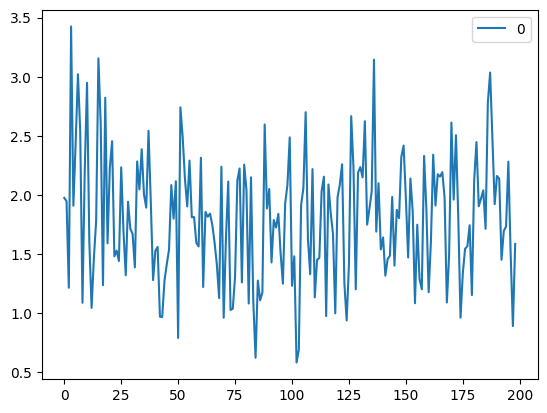

In [25]:
pd.DataFrame(bopt.distances_).plot()

## <strong> XX | Demo 0 </strong>

In [238]:
TRUSS1_bopt = BayesianOptimizer(target_func=LF_wrapper, x_init=x_list, y_init=y_list, n_iter=100, batch_size=50, bounds=x_bounds)
optimal_x, y_max = TRUSS1_bopt.optimize()

Iteration: 0 Best loss = 0.80



c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 13 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      16.7334 | [6.767225014673432, 15.291208275591426, 23.967045625312604] |         11349.7 |                      1 |             3.93334 |                        0 |                      3.93334 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.707662 | [17.308558980002683, 46.295120831849786, 53.92495510103823] |         3365.04 |               0.296486 |            0.102794 |                        0 |                     0.102794 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                       |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+===========================================================+=================+========================+=====================+==========================+==============================+
| Value    |      13.7842 | [5.051882271614813, 18.40554884605641, 35.66214247797545] |         2907.83 |               0.256203 |             3.38201 |                        0 |                      3.38201 |
+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+----

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                       |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+===========================================================+=================+========================+=====================+==========================+==============================+
| Value    |      9.23005 | [6.404394256392112, 24.04689429307897, 48.67411986826752] |         5365.66 |               0.472757 |             2.18932 |                        0 |                      2.18932 |
+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+----

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+--------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                          |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+==============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      1.75505 | [13.553764928755278, 37.106520421874784, 52.883386608673014] |         1277.71 |               0.112576 |             0.41062 |                        0 |                      0.41062 |
+----------+--------------+--------------------------------------------------------------+-----------------+------------------------+-----------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 12 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      9.07875 | [3.8776085508389353, 55.075658542394564, 68.05751614609541] |         2280.38 |                0.20092 |             2.21946 |                        0 |                      2.21946 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 16 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      5.03186 | [11.161734605107469, 27.182462995316897, 44.26071610422961] |         1605.42 |                0.14145 |              1.2226 |                        0 |                       1.2226 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 9 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 10 of parameter k2__length_scale is close to the specified upper bound 10000000000.0.

+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      17.1336 | [3.929346466898654, 9.784495501559313, 59.508713472680945] |         10392.7 |               0.915676 |             4.05447 |                        0 |                      4.05447 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 11 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                       |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+===========================================================+=================+========================+=====================+==========================+==============================+
| Value    |      4.49016 | [8.598462917208284, 42.99152547842351, 56.06982960137002] |         1047.86 |              0.0923247 |             1.09946 |                        0 |                      1.09946 |
+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+----

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 9 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.574311 | [22.432522292782842, 57.37741257907098, 77.53636603486015] |          2145.6 |               0.189044 |           0.0963168 |                        0 |                    0.0963168 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                      |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+==========================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.433361 | [20.90898613393924, 56.7163641174171, 74.98358784108673] |         1568.35 |               0.114592 |           0.0796923 |                        0 |                    0.0796923 |
+----------+--------------+----------------------------------------------------------+-----------------+------------------------+---------------------+---------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 19 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.677519 | [15.693232809992326, 40.08351178870988, 58.835710924925955] |         937.612 |              0.0542176 |            0.155825 |                        0 |                     0.155825 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 14 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      19.5633 | [3.7527774851238855, 15.299035686257737, 21.70641547580905] |         4300.21 |                0.24866 |             4.82867 |                        0 |                      4.82867 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      16.5769 | [3.4039160312735404, 17.529557815029207, 33.52690148739543] |         10247.2 |               0.592544 |             3.99608 |                        0 |                      3.99608 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 14 of parameter k2__length_scale is close to the specified upper bound 10000000000.0.

+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      8.95354 | [7.417768323462324, 28.63401506134253, 35.340668189946854] |         6013.85 |               0.347752 |             2.15145 |                        0 |                      2.15145 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 15 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                       |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+===========================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.720376 | [17.503106304937035, 59.9890053173414, 74.84327802766427] |         1694.63 |              0.0979922 |            0.155596 |                        0 |                     0.155596 |
+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+----

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 16 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      10.6389 | [7.349020340515394, 19.958832879100175, 38.03139166862151] |         2930.06 |               0.169431 |             2.61736 |                        0 |                      2.61736 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      1.74196 | [13.580192036579716, 37.13786268274324, 51.690493834979364] |         763.727 |              0.0441626 |            0.424449 |                        0 |                     0.424449 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 18 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                      |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+==========================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.271757 | [18.037648967711, 48.040236500238215, 58.71933201832229] |         1443.16 |              0.0834511 |           0.0470766 |                        0 |                    0.0470766 |
+----------+--------------+----------------------------------------------------------+-----------------+------------------------+---------------------+---------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      5.32472 | [10.843703307868847, 29.27753075520878, 39.91210237868098] |         1340.19 |              0.0774968 |              1.3118 |                        0 |                       1.3118 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 9 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+--------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                          |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+==============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      22.4135 | [2.6884415708699145, 12.547076640240366, 20.689527161487096] |         7261.53 |               0.419899 |             5.49839 |                        0 |                      5.49839 |
+----------+--------------+--------------------------------------------------------------+-----------------+------------------------+-----------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 15 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                       |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+===========================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.491249 | [18.967162567278244, 58.8864034825624, 73.86273144639665] |         1509.16 |              0.0872674 |            0.100995 |                        0 |                     0.100995 |
+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+----

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.459559 | [21.512783684033177, 50.89099707247598, 83.75453881397897] |         2491.89 |               0.144094 |           0.0788663 |                        0 |                    0.0788663 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. 

+----------+--------------+--------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                          |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+==============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      1.91013 | [15.490032685514823, 37.120791346073354, 42.723566650762955] |         996.011 |              0.0575945 |            0.463135 |                        0 |                     0.463135 |
+----------+--------------+--------------------------------------------------------------+-----------------+------------------------+-----------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 11 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.132462 | [20.609442623208743, 43.64512018972794, 61.235589326689016] |         2068.06 |               0.119586 |          0.00321898 |                        0 |                   0.00321898 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      1.48265 | [15.178673731135294, 34.171921744942885, 50.4313735526288] |         1481.21 |              0.0856514 |             0.34925 |                        0 |                      0.34925 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 14 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      22.9278 | [3.044276951509358, 12.313892095550173, 18.046398487183577] |         7574.68 |               0.438007 |             5.62245 |                        0 |                      5.62245 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                      |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+==========================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.664945 | [20.44106585199701, 60.5124205852125, 84.70599173995397] |         1514.82 |              0.0875947 |            0.144338 |                        0 |                     0.144338 |
+----------+--------------+----------------------------------------------------------+-----------------+------------------------+---------------------+---------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      2.14978 | [12.625868534767866, 54.33395420993257, 73.29462666508576] |         1738.16 |               0.100509 |            0.512319 |                        0 |                     0.512319 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 11 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      16.9395 | [5.716815677581404, 17.109606167932256, 21.39906144525267] |          4394.1 |                0.25409 |             4.17134 |                        0 |                      4.17134 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 18 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.906553 | [15.234457852738178, 41.00028318583746, 62.38351403140815] |         2535.26 |               0.146602 |            0.189988 |                        0 |                     0.189988 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 11 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 18 of parameter k2__length_scale is close to the specified upper bound 10000000000.0

+----------+--------------+--------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                          |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+==============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      13.4881 | [6.7055963929550515, 19.987039214735297, 26.754167459262444] |         2860.09 |               0.165385 |             3.33067 |                        0 |                      3.33067 |
+----------+--------------+--------------------------------------------------------------+-----------------+------------------------+-----------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 11 of parameter k2__length_scale is close to the specified upper bound 10000000000.0.

+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      2.42518 | [12.529206529695445, 60.22483196807682, 78.46128700465528] |         1688.86 |              0.0976589 |            0.581881 |                        0 |                     0.581881 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 12 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                       |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+===========================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.902378 | [18.508134174486624, 65.3196416778228, 83.22697428046735] |         1628.01 |              0.0941399 |            0.202059 |                        0 |                     0.202059 |
+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+----

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 9 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 17 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.581003 | [20.122446104771395, 60.09833164855509, 74.16322657328425] |         2940.57 |               0.170039 |            0.102741 |                        0 |                     0.102741 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 9 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 11 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 15 of parameter k2__length_scale is close to the specified upper bound 10000000000.0

+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      3.18624 | [11.272049044635933, 44.912722272857714, 49.05583076597825] |         3169.53 |               0.183279 |             0.75074 |                        0 |                      0.75074 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 9 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 10 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 11 of parameter k2__length_scale is close to the specified upper bound 10000000000.0

+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                       |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+===========================================================+=================+========================+=====================+==========================+==============================+
| Value    |      1.15617 | [22.88162725724555, 71.93588672296481, 83.05297274770325] |         1413.59 |               0.081741 |            0.268607 |                        0 |                     0.268607 |
+----------+--------------+-----------------------------------------------------------+-----------------+------------------------+---------------------+----

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 17 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      1.09038 | [16.375778719684053, 34.183092822435675, 51.96015360935137] |         2268.47 |               0.131175 |            0.239802 |                        0 |                     0.239802 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 12 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      1.10185 | [14.664902198867425, 37.01751949802721, 65.43302724680414] |         1176.14 |              0.0680105 |            0.258459 |                        0 |                     0.258459 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 16 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |       21.154 | [3.0364678013859554, 12.066227979874897, 25.80198407757204] |           12589 |                0.72796 |              5.1065 |                        0 |                       5.1065 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |     0.075282 | [19.484431004405877, 39.86150570746005, 58.95148532711061] |         1075.48 |                0.06219 |            0.003273 |                        0 |                     0.003273 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 15 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 17 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                        |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+============================================================+=================+========================+=====================+==========================+==============================+
| Value    |      15.3487 | [5.801550498762051, 16.533453345012827, 27.39922306393618] |         1790.42 |               0.103531 |              3.8113 |                        0 |                       3.8113 |
+----------+--------------+------------------------------------------------------------+-----------------+------------------------+---------------------

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 11 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),
c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 15 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  "better value." % (dim, hyp.name, hyp.bounds[dim][0]),


+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+--------------------------+------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Imaginary Part Penalty |   Constraint Violation Level |
+==========+==============+=============================================================+=================+========================+=====================+==========================+==============================+
| Value    |       0.1235 | [18.85979160339803, 39.262786727961625, 63.354098150386804] |         1235.94 |              0.0714683 |           0.0130079 |                        0 |                    0.0130079 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+----------------

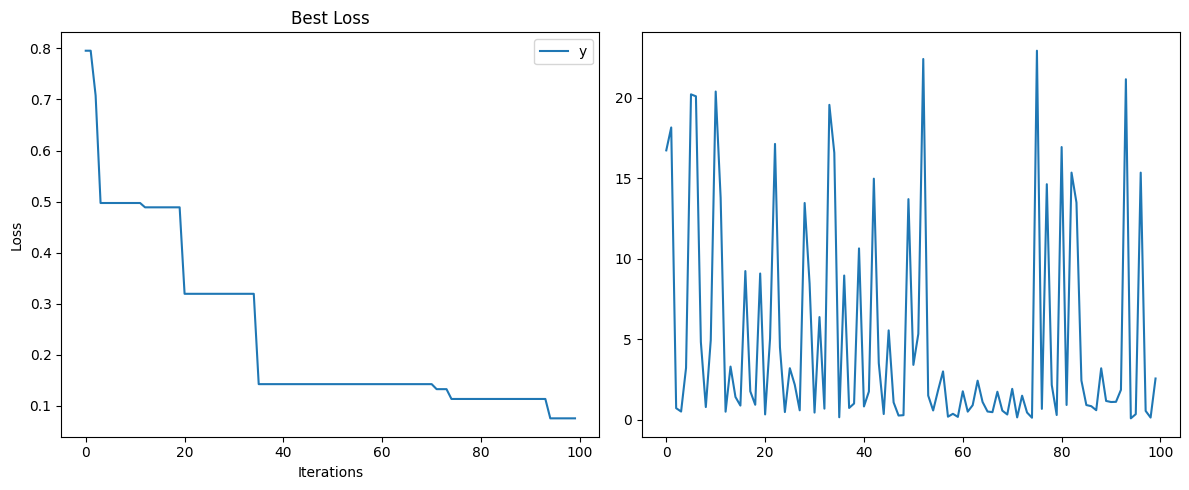

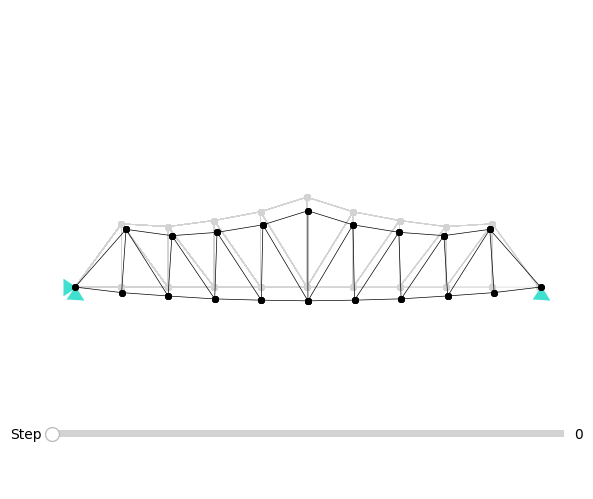

In [239]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
pd.DataFrame(TRUSS1_bopt.best_samples_['y']).plot(ax=plt.subplot(1, 2, 1), title='Best Loss', xlabel='Iterations', ylabel='Loss')
plt.subplot(1, 2, 2).plot(TRUSS1_bopt.y_loss)

plt.tight_layout()
plt.show()
plot_truss(write_file_path,TRUSS1, TRUSS1.cross_sections) ## FIX THIS

In [240]:
TRUSS1.y_coordinates

array([0.        , 0.        , 1.3644831 , 0.        , 1.30550019,
       0.        , 1.43596906, 0.        , 1.62515407, 0.        ,
       1.93979369, 0.        , 1.62515407, 0.        , 1.43596906,
       0.        , 1.30550019, 0.        , 1.3644831 , 0.        ])